Axl Adilla <br>
20/466397/PPA/05963

UAS Data Science

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('gojek_twitter_dataset.csv')
dataset.head()

,tweet,sentimen
0,Saya juga mau vouchee @gojekindonesia https:/...,1
1,download gojek duluuu uwuwu,1
2,Aminnn...#orderan goride mhn di lancar kan.all...,1
3,Tq @gojekindonesia @golifeindonesia 🖤. Harusny...,1
4,Semoga Twitter panjang umur. Berkomunikasi den...,1


In [3]:
dataset['sentimen'].value_counts()

0    3062
1     938
Name: sentimen, dtype: int64

In [4]:
dataset_class_0 = dataset[dataset['sentimen'] == 0]
dataset_class_1 = dataset[dataset['sentimen'] == 1]

In [5]:
dataset_class_1_over = dataset_class_1.sample(3062, replace=True)

In [6]:
dataset_class_0_under = dataset_class_0.sample(938, replace=True)

In [7]:
dataset = pd.concat([dataset_class_0, dataset_class_1_over], axis=0)
dataset['sentimen'].value_counts()

0    3062
1    3062
Name: sentimen, dtype: int64

In [8]:
dataset_y = dataset['sentimen'].copy().values
dataset_y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [9]:
dataset_x = dataset['tweet'].copy().values
dataset_x

array(['Iyaa min akur dong :((( biar saldoku tida terpisah bagaikan adam dan hawa waktu itu :””',
       "hayu tolong dibantuin! \n@gojekindonesia\n@gojek24jam\n@infodepok_id\n@CCICPolri \nuntung mba nya nyalain data hp, jd bisa di lacak:') https://twitter.com/yuniarayutyas/status/1167387194496962560\xa0…",
       'sengaja banget nih orang... \nsumpah nyeaeeek banget gue.... \nsalah gak salah driver ttp nanggung deritanya  \n\n@gojekindonesia  pic.twitter.com/T9mmC1AlBD',
       ...,
       'Kita Diberkati Untuk Memberkati Salam Penuh Damay Sejahrta Bersuka Cita Senan Tiasa TUHAN Memberkati Kita Semua Amin  Slamat Melanjutkan  Beraktivitas n Happiness  All  🙏😍💐🤝🇮🇩❤',
       '@gojekindonesia',
       '@gojekindonesia kenapa malah akun saya dibekuin? Saya cancel krn emang makanannya ga available. Nyusahin ini namanya.  pic.twitter.com/jXgUvHsXh7'],
      dtype=object)

In [10]:
import re
def remove_link(text):
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*.com\S*', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\S*\s', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S*#\S*', '', text, flags=re.MULTILINE)
    return text

In [11]:
def remove_number_symbol(text):
    text = re.sub(r'\d.', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z]', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

In [12]:
import emoji
def remove_emoji(text):
    text = emoji.get_emoji_regexp().sub("", text)
    return text

In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text)
    listStopword =  set(stopwords.words('indonesian'))

    removed = []
    for t in tokens:
        if t not in listStopword:
            removed.append(t)
    return " ".join(removed)

In [14]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

sastrawi_factory = StemmerFactory()
sastrawi_stemmer = sastrawi_factory.create_stemmer()
def stemming(text):
    text = sastrawi_stemmer.stem(text)
    return text

In [15]:
def preprocessing_data(text):
    text = remove_link(text)
    text = remove_emoji(text)
    text = remove_number_symbol(text)
    text = remove_stopwords(text)
    text = stemming(text)
    
    return text

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, random_state=1, test_size=0.7 )
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [17]:
from torch.utils.data import Dataset
import torch

class GojekDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_len=128):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, item):
        sentence_1 = self.inputs[item]
        sentence_1 = preprocessing_data(sentence_1)
        
        encoding_sentence_1 = self.tokenizer.get_sentence_vector(sentence_1)
        target = self.targets[item]
        return {
            'sentence_1': sentence_1,
            'targets': torch.tensor(target, dtype=torch.long),
            'encoding_1' : encoding_sentence_1,
        }

In [18]:
from torch import nn
import torch
from transformers import AutoModel

class ClassifierModel(nn.Module):
    def __init__(self, input_size, device):
        super(ClassifierModel, self).__init__()
        self.input_size = input_size
        self.device = device
        
        self.out = nn.Sequential(
            nn.Linear(int(self.input_size), 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, vector):
        out = self.out(vector)
        sigmoid = self.sigmoid(out)
        sigmoid_reshape = torch.reshape(sigmoid, (sigmoid.shape[0], sigmoid.shape[-1]))
        return sigmoid_reshape

In [19]:
from torch.utils.data import DataLoader 
def create_data_loader(inputs, targets, tokenizer, max_len=128, batch_size=1):
    ds = GojekDataset(
        inputs=inputs,
        targets=targets,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

In [20]:
import numpy as np
def train_epoch(
        clf_model,
        data_loader,
        loss_fn,
        optimizer,
        n_examples,
        device
    ):
    
    clf_model = clf_model.train()
    losses = []
    correct_prediction = 0
    counting = 0
    for d in data_loader:
        counting = counting+1
        targets = d['targets'].to(device)
        encoding_1 = d["encoding_1"].to(device)

        outputs = clf_model(encoding_1)

        y_pred, y_pred_max = torch.max(outputs, dim=1)
        loss = loss_fn(outputs.float(), targets)
        

        correct_prediction += torch.sum(y_pred_max == targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_prediction.double() / n_examples, np.mean(losses)

In [21]:
def eval_epoch(
        clf_model,
        data_loader,
        loss_fn,
        n_examples,
        device
    ):
    
    clf_model = clf_model.eval()
    losses = []
    with torch.no_grad():
        counting = 0
        correct_prediction = 0
        for d in data_loader:
            counting = counting+1
            targets = d['targets'].to(device)
            encoding_1 = d["encoding_1"].to(device)

            outputs = clf_model(encoding_1)
            y_pred, y_pred_max = torch.max(outputs, dim=1)
            
            loss = loss_fn(outputs.float(), targets)
            correct_prediction += torch.sum(y_pred_max == targets)
            losses.append(loss.item())
        
    return correct_prediction.double() / n_examples, np.mean(losses)

In [22]:
def pred_test(
        clf_model,
        data_loader,
        device
    ):
    
    clf_model = clf_model.eval()
    losses = []
    tot_y_pred_max = []
    tot_targets = []
    tot_y_pred = []
    with torch.no_grad():
        correct_prediction = 0
        counting = 0
        for d in data_loader:
            counting = counting+1
            targets = d['targets'].to(device)
            encoding_1 = d["encoding_1"].to(device)

            outputs = clf_model(encoding_1)
            y_pred, y_pred_max = torch.max(outputs, dim=1)
            
            [tot_y_pred_max.append(pred_max) for pred_max in y_pred_max.tolist()]
            [tot_y_pred.append(pred) for pred in y_pred.tolist()]
            [tot_targets.append(target) for target in targets.tolist()]

    return tot_y_pred, tot_y_pred_max, tot_targets

In [23]:
import torch
import fasttext

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 100
max_len=32
batch_size = 64
EPOCH = 100
learning_rate = 0.05

tokenizer = fasttext.load_model("cc.id.100.bin")

In [24]:
import time
from torch import nn
from collections import defaultdict

clf_model = ClassifierModel(input_size, device)
clf_model = clf_model.to(device)

train_data_loader = create_data_loader(x_train, y_train, tokenizer=tokenizer, max_len=max_len, batch_size=batch_size)
test_data_loader = create_data_loader(x_test, y_test, tokenizer=tokenizer, max_len=max_len, batch_size=batch_size)
val_data_loader = create_data_loader(x_val, y_val, tokenizer=tokenizer, max_len=max_len, batch_size=batch_size)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clf_model.parameters(), lr=learning_rate)

history = defaultdict(list)
best_acc = -1

end_train = -1
start_train = time.process_time()
for epoch in range(EPOCH):

    print(f'Epoch {epoch + 1}/{EPOCH}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
            clf_model,
            train_data_loader,    
            loss_fn, 
            optimizer,
            len(x_train),
            device
        )

    val_acc, val_loss = eval_epoch(
            clf_model,
            val_data_loader,    
            loss_fn,
            len(x_val),
            device
        )

    cpu_train_acc = train_acc.cpu()
    cpu_val_acc = val_acc.cpu()

    print(f'Train Acc  : {train_acc} ')
    print(f'Validation Acc : {val_acc} ')
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(cpu_train_acc)
    history['val_acc'].append(cpu_val_acc)
    
    if val_acc > best_acc:
        torch.save(clf_model.state_dict(), 'best_model_state.bin')
        best_acc = val_acc

if end_train == -1:
    end_train = time.process_time() - start_train

Epoch 1/100
----------
Train Acc  : 0.5221238938053097 
Validation Acc : 0.5978260869565217 
Epoch 2/100
----------
Train Acc  : 0.59428182437032 
Validation Acc : 0.6385869565217391 
Epoch 3/100
----------
Train Acc  : 0.6569094622191967 
Validation Acc : 0.6521739130434783 
Epoch 4/100
----------
Train Acc  : 0.6848196051735874 
Validation Acc : 0.6331521739130435 
Epoch 5/100
----------
Train Acc  : 0.7031994554118447 
Validation Acc : 0.6195652173913043 
Epoch 6/100
----------
Train Acc  : 0.6827773995915588 
Validation Acc : 0.6168478260869565 
Epoch 7/100
----------
Train Acc  : 0.6255956432947583 
Validation Acc : 0.6005434782608695 
Epoch 8/100
----------
Train Acc  : 0.6766507828454731 
Validation Acc : 0.6304347826086957 
Epoch 9/100
----------
Train Acc  : 0.6446562287270251 
Validation Acc : 0.6032608695652174 
Epoch 10/100
----------
Train Acc  : 0.6820966643975493 
Validation Acc : 0.6277173913043478 
Epoch 11/100
----------
Train Acc  : 0.6841388699795778 
Validation Acc

Train Acc  : 0.7957794417971409 
Validation Acc : 0.6630434782608695 
Epoch 90/100
----------
Train Acc  : 0.789652825051055 
Validation Acc : 0.6331521739130435 
Epoch 91/100
----------
Train Acc  : 0.7821647379169503 
Validation Acc : 0.6603260869565217 
Epoch 92/100
----------
Train Acc  : 0.7978216473791695 
Validation Acc : 0.6086956521739131 
Epoch 93/100
----------
Train Acc  : 0.789652825051055 
Validation Acc : 0.6494565217391304 
Epoch 94/100
----------
Train Acc  : 0.7950987066031313 
Validation Acc : 0.6413043478260869 
Epoch 95/100
----------
Train Acc  : 0.8012253233492171 
Validation Acc : 0.6603260869565217 
Epoch 96/100
----------
Train Acc  : 0.7787610619469026 
Validation Acc : 0.654891304347826 
Epoch 97/100
----------
Train Acc  : 0.7855684138869979 
Validation Acc : 0.6385869565217391 
Epoch 98/100
----------
Train Acc  : 0.7828454731109598 
Validation Acc : 0.6385869565217391 
Epoch 99/100
----------
Train Acc  : 0.7903335602450646 
Validation Acc : 0.66032608695

Plotting


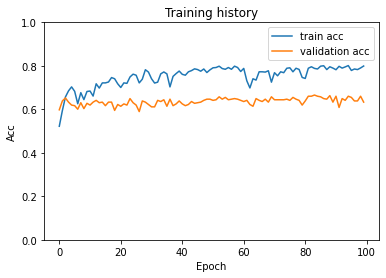

In [25]:
import matplotlib.pyplot as plt 
print(f'Plotting')
print('='*10)
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')

plt.title('Training history')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.savefig('report_nn_model')

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

print(f'Load Best Model')
print('='*10)
best_model = ClassifierModel(input_size, device)
best_model.load_state_dict(torch.load('best_model_state.bin'))
best_model.eval()
best_model = best_model.to(device)

print(f'Calc Pred')
print('='*10)
y_pred, y_pred_max, y_test = pred_test(
            best_model,
            test_data_loader,
            device    
        )

classif_report = classification_report(y_test, y_pred_max)
confus_matrix = confusion_matrix(y_test, y_pred_max)

print(classif_report)
print(confus_matrix)

Load Best Model
Calc Pred
              precision    recall  f1-score   support

           0       0.67      0.77      0.71      2147
           1       0.73      0.61      0.66      2140

    accuracy                           0.69      4287
   macro avg       0.70      0.69      0.69      4287
weighted avg       0.70      0.69      0.69      4287

[[1651  496]
 [ 831 1309]]


In [27]:
y_pred, y_pred_max, y_test = pred_test(
            best_model,
            train_data_loader,
            device    
        )

classif_report = classification_report(y_train, y_pred_max)
confus_matrix = confusion_matrix(y_train, y_pred_max)

print(classif_report)
print(confus_matrix)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       738
           1       0.86      0.70      0.77       731

    accuracy                           0.79      1469
   macro avg       0.81      0.79      0.79      1469
weighted avg       0.81      0.79      0.79      1469

[[658  80]
 [222 509]]
